In [1]:
import torch
import wandb
import pprint
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
import os
os.environ["http_proxy"]="http://proxy61.iitd.ac.in:3128"
os.environ["https_proxy"]="http://proxy61.iitd.ac.in:3128"

In [3]:
track_columns = ['new node test average_precision',
 'train roc_auc',
 'new node val first_3_roc_auc',
 'new node test first_3_roc_auc',
 'new node test first_3_average_precision',
 'new node val average_precision',
 'new node val first_1_average_precision',
 'new node test first_1_average_precision',
 'new node test first_1_roc_auc',
 'new node test first_10_roc_auc',
 'new node val first_3_average_precision',
 'val average_precision',
 'val roc_auc',
 'new node val roc_auc',
 'new node val first_10_average_precision',
 'new node test roc_auc',
 'train average_precision',
 'test roc_auc',
 'new node val first_1_roc_auc',
 'new node val first_10_roc_auc',
 'test average_precision',
 'new node test first_10_average_precision',
 'train_acc_hist',
 'val_acc_hist',
 'new node val_acc_hist',
 'test_acc_hist',
 'new node test_acc_hist',
 ]
import pandas as pd 
import wandb
api = wandb.Api()

runs = api.runs("fb-graph-proj/fb-graph-proj-dyglib", )

for cnt, run in enumerate(tqdm(runs[:6])):
    # Find epoch with best avg precision
    update_run(run)

  0%|          | 0/6 [00:00<?, ?it/s]

NameError: name 'update_run' is not defined

In [7]:
def update_run(run):
  val_key = 'val average_precision'
  hist = run.history(samples = 200, keys = [val_key])
  hist= hist[val_key]
  best_epoch_num_test = np.argmax(hist[9::10])
  best_epoch_num = np.argmax(hist)
  print(run.name)
  print(best_epoch_num)
  for key in track_columns:
    hist = run.history(samples = 200, keys = [key])[key]
    # print(f"From {run.summary[key]} to ", end ="")
    if 'test' in key:
      run.summary[key] = hist[best_epoch_num_test]
      # print(f"{run.summary[key]}")
    else:
      run.summary[key] = hist[best_epoch_num]
      # print(f"{run.summary[key]}")
  run.summary.update()

## Table Generation

In [3]:
def get_table(filters, metrics, row_name):
  api = wandb.Api()
  runs = api.runs("fb-graph-proj/fb-graph-proj-dyglib")
  # Retrieve relevant runs
  return_runs = []
  for run in runs:
    flag = True
    for filter_key, filter_val in filters.items():
      if 'use_init_method' not in run.config:
        flag = False
      elif filter_key == 'run_name' and run.config['use_init_method'] == False:
        run.config['init_weights'] = "old"
      elif type(filter_val) == str and filter_val not in run.config[filter_key]:
        flag = False
      elif type(filter_val) != str and run.config[filter_key] == filter_val:
        flag = False
    if flag:
      return_runs.append(run)

  row_names = ["-".join([run.config[rn] for rn in row_name]) if row_name[0] in run.config else 'old' for run in return_runs ]
  for run in return_runs:
    if 'test average_precision' not in run.summary:
      x= 1
  return pd.DataFrame({metric: [round(100 * run.summary[metric], 2) for run in return_runs] for metric in metrics}, index = row_names)
def print_df_as_markdown(df):
    # Print header row
    df.sort_index(inplace = True)
    header = ["Index"] + list(df.columns)
    print("| " + " | ".join(header) + " |")
    
    # Print separator row
    print("| " + " | ".join([" --- " for _ in header]) + " |")
    
    # Print data rows
    for index, row in df.iterrows():
        data_row = [index]
        for col in df.columns:
            if row[col] == df[col].max():
                data_row.append("***" + str(row[col]) + "***")
            else:
                data_row.append(str(row[col]))
        print("| " + " | ".join(data_row) + " |")

In [4]:
data_names = ['ia-reality-call', 'ia-retweet-pol', 'ia-movielens-user2tags-10m', 'ia-slashdot-reply-dir', 'ia-escorts-dynamic', 'ia-digg-reply']

In [8]:
for data_name in data_names:
  print(data_name)
  table = get_table({
    "run_name": "old",
    "dataset": data_name, 
    "model": "DyGFormer",
    }, ["test average_precision", "new node test average_precision"], ["init_weights"])
  print_df_as_markdown(table)

ia-reality-call


KeyError: 'test average_precision'

ia-reality-call
| Index | test average_precision | new node test average_precision |
|  ---  |  ---  |  ---  |
| old | ***95.39*** | ***90.55*** |
| time-exp | 92.81 | 87.55 |
| time-linear | 90.52 | 88.43 |
ia-retweet-pol
| Index | test average_precision | new node test average_precision |
|  ---  |  ---  |  ---  |
| old | ***84.07*** | ***67.29*** |
| time-exp | 71.59 | 61.18 |
ia-movielens-user2tags-10m
| Index | test average_precision | new node test average_precision |
|  ---  |  ---  |  ---  |
| old | ***84.6*** | ***68.35*** |
| time-exp | 71.92 | 63.36 |
| time-linear | 72.88 | 65.23 |
ia-slashdot-reply-dir
| Index | test average_precision | new node test average_precision |
|  ---  |  ---  |  ---  |
| old | ***78.47*** | ***61.17*** |
| time-exp | 72.87 | 52.24 |
| time-linear | 73.91 | 53.0 |
ia-escorts-dynamic
| Index | test average_precision | new node test average_precision |
|  ---  |  ---  |  ---  |
| old | 88.1 | 74.39 |
| time-exp | 88.05 | 73.97 |
| time-linear | ***88.99*** | ***75.6*** |
ia-digg-reply
| Index | test average_precision | new node test average_precision |
|  ---  |  ---  |  ---  |
| old | ***74.5*** | ***56.91*** |
| time-exp | 72.46 | 56.27 |
| time-linear | 71.14 | 54.42 |

In [9]:
for data_name in data_names:
  print(data_name)
  table = get_table({"run_name": "0204", "dataset": data_name}, ["test average_precision", "new node test average_precision"], ["init_weights"])
  print_df_as_markdown(table)

| Index | test average_precision | new node test average_precision |
|  ---  |  ---  |  ---  |
| old | 97.3 | 94.69 |
| time-exp | ***97.89*** | ***95.15*** |
| Index | test average_precision | new node test average_precision |
|  ---  |  ---  |  ---  |
| old | 89.88 | 75.3 |
| time-exp | ***90.29*** | ***75.83*** |
| Index | test average_precision | new node test average_precision |
|  ---  |  ---  |  ---  |
| old | ***89.51*** | ***79.63*** |
| time-exp | 89.5 | 79.41 |
| Index | test average_precision | new node test average_precision |
|  ---  |  ---  |  ---  |
| old | ***89.46*** | ***87.12*** |
| time-exp | 86.15 | 74.08 |
| Index | test average_precision | new node test average_precision |
|  ---  |  ---  |  ---  |
| old | 88.26 | 74.14 |
| time-exp | ***88.69*** | ***75.59*** |
| Index | test average_precision | new node test average_precision |
|  ---  |  ---  |  ---  |
| old | 80.91 | ***65.63*** |
| time-exp | ***82.43*** | 65.56 |


In [35]:
table = get_table({"run_name": "repcorr", "dataset": data_name}, ["test average_precision", "new node test average_precision"], ["init_weights"])
print_df_as_markdown(table)

| Index | test average_precision | new node test average_precision |
|  ---  |  ---  |  ---  |
| old | ***80.91*** | ***65.63*** |
| time-exp | 71.38 | 59.81 |
| time-linear | 72.53 | 58.5 |


# Plotting time transformation function

In [11]:
import sys
sys.path += ['/home/ayush/DyGLib/']
from models.MemoryModel import *
data_names = ['ia-reality-call', 'ia-retweet-pol', 'ia-movielens-user2tags-10m', 'ia-slashdot-reply-dir', 'ia-escorts-dynamic', 'ia-digg-reply']
num_nodes = [27046, 18471, 16530, 51085, 10108, 30400]

def plot_all(call = 'exp', init_weights = 'time-exp', name = 'maint', number = 0):
  data_name = data_names[number]
  num_node = num_nodes[number]
  run_name = "TGN_seed0_" + data_name + f"{name}-{init_weights}"
  save_model_path = f"/home/ayush/DyGLib/saved_models/TGN/{data_name}/TGN_seed0_tgn-{data_name}-{name}-{init_weights}/TGN_seed0_tgn-{data_name}-{name}-{init_weights}.pkl"
  dynamic_backbone = MemoryModel(node_raw_features=np.zeros((num_node, 172)), edge_raw_features=np.zeros((1720, 172)), neighbor_sampler = None, time_feat_dim=100, model_name="TGN", num_layers=1, num_heads=2, dropout=0.1, min_time=1, use_init_method=True, init_weights=init_weights)
  dynamic_backbone.mlp_for_mean = nn.Sequential(
              nn.Linear(dynamic_backbone.memory_dim, dynamic_backbone.memory_dim)
          )
  link_predictor = MergeLayer(
                  input_dim1=172,
                  input_dim2=172,
                  hidden_dim=172,
                  output_dim=1,
              )
  model = nn.Sequential(dynamic_backbone, link_predictor)
  try:
    model.load_state_dict(torch.load(save_model_path, map_location=None), strict=False)
    x = (torch.arange(0, 500)/500).reshape(-1, 1)
    tt = model[0].time_transformation_for_init
    if call == 'exp':
      lin_out = tt.lin(-x).reshape(-1)
      y = torch.exp(-torch.square(lin_out))
    if call == 'linear':
      y = tt.lin(-x).reshape(-1)
    if call == 'fourier':
      zeros = -x.reshape(-1, 1)
      exp_out = (torch.cos(zeros.unsqueeze(-1) * tt.mask.unsqueeze(0).unsqueeze(1)) * tt.lin[:tt.k]).sum(dim = 2) + torch.sin(zeros.unsqueeze(-1) * tt.mask.unsqueeze(0).unsqueeze(1)  * tt.lin[tt.k:]).sum(dim = 2)
      y = exp_out.reshape(-1)
    if call == 'mlp' or call == 'mlp2':
      y = tt.mlp_for_time(-x.reshape(-1, 1)).reshape(-1)
    if call == '3unite':
      lin_out = tt.exp.lin(-x).reshape(-1)
      y1 = tt.lamb1 * torch.exp(-torch.square(lin_out))
      y2 = tt.lamb2 * tt.linear.lin(-x).reshape(-1)
      y3 = tt.lamb3
      y = y1 + y2 + y3
    plt.plot((1 - x).tolist(), y.tolist())
    # print(model[0].min_time)
    return True
  except Exception as e:
    print(e)
    return False
  
  
def plot_all_all(call = 'exp', name = 'maint'):
  legends = []
  for j in range(6):
    mask = plot_all(call=f'{call}', init_weights=f'time-{call}', name = name, number=j)
    if mask:
      legends.append(data_names[j])
  plt.title(f'{name}: time-{call}')
  plt.legend(legends)
  plt.xlabel(r'Time t: Earliest $\rightarrow$$\rightarrow$$\rightarrow$$\rightarrow$ current')
  plt.ylabel(r'Weight $w(t)$')
  plt.show()
  plt.close()

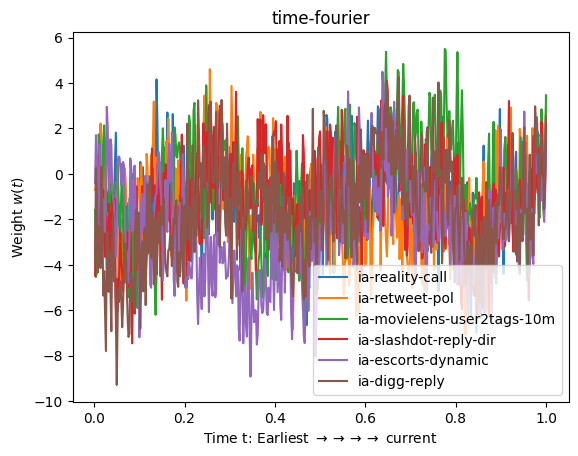

In [5]:
plot_all_all('fourier')

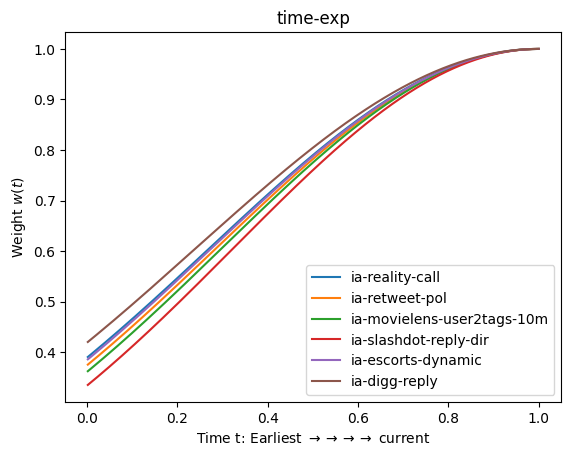

In [6]:
plot_all_all('exp')

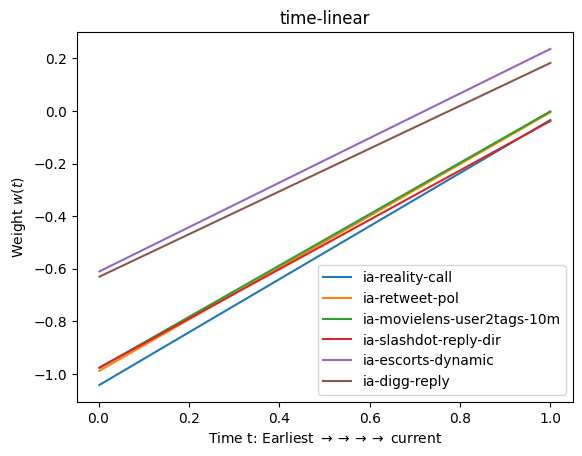

In [65]:
plot_all_all('linear')

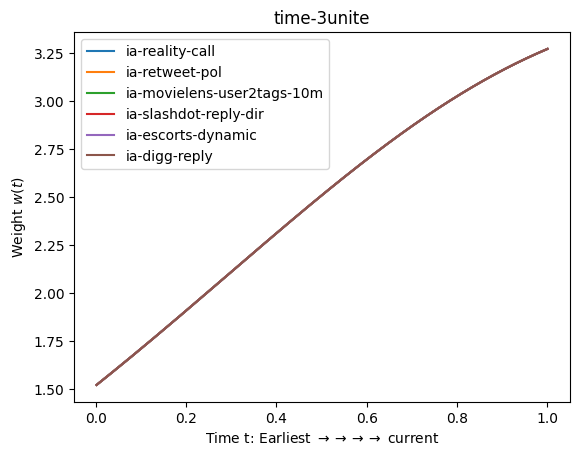

In [66]:
plot_all_all('3unite')

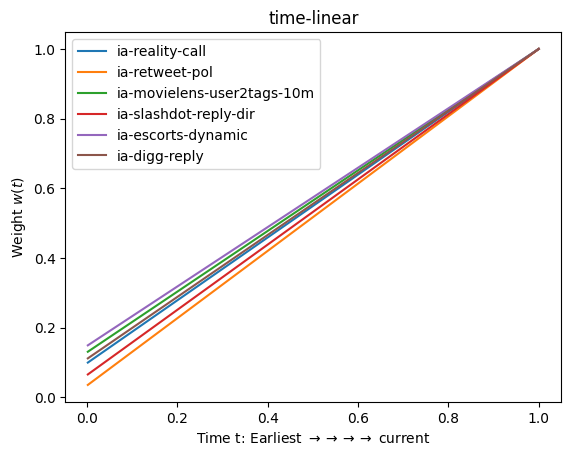

In [4]:
plot_all_all('linear', 'lincorrect')

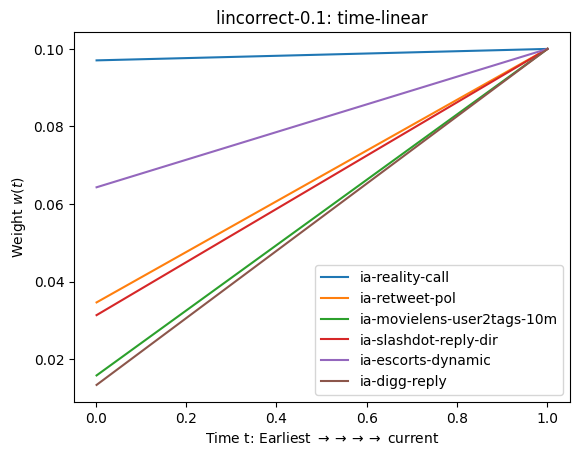

In [12]:
plot_all_all('linear', 'lincorrect-0.1')

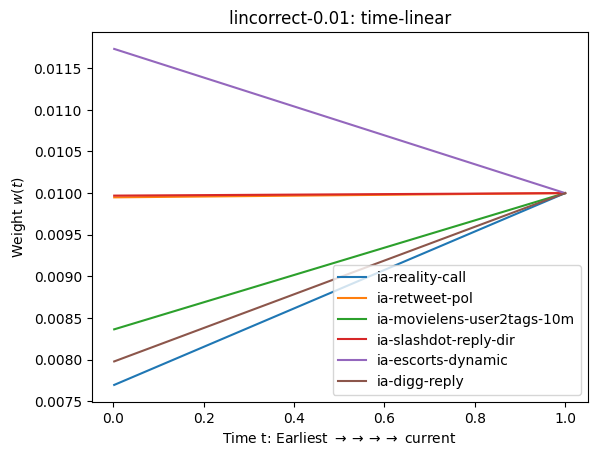

In [13]:
plot_all_all('linear', 'lincorrect-0.01')

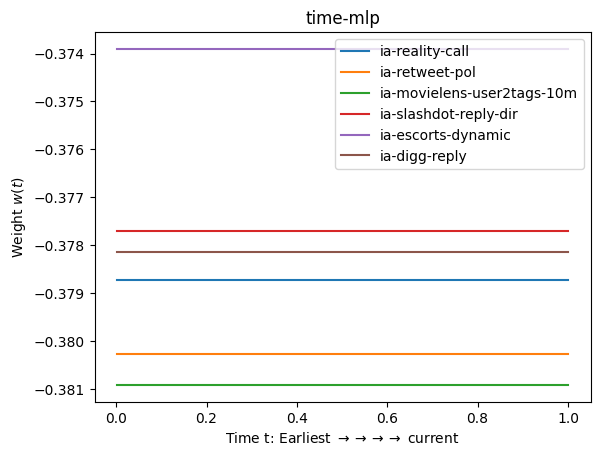

In [8]:
plot_all_all('mlp')

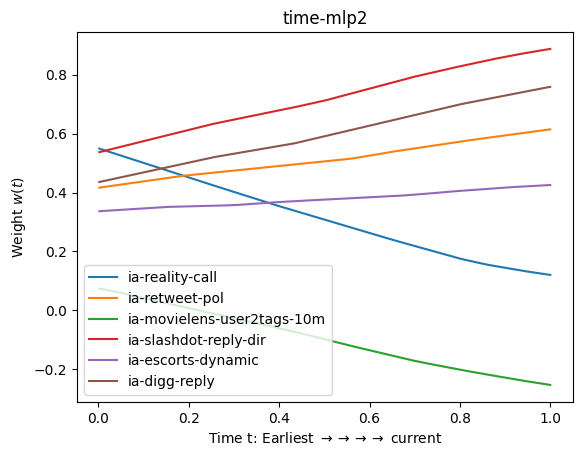

In [9]:
plot_all_all('mlp2')

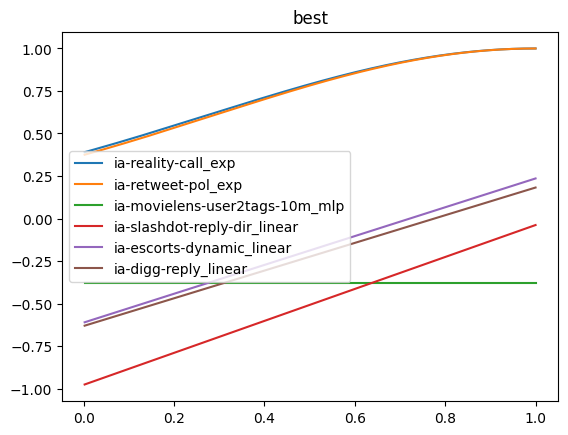

: 

In [10]:
best_ones = ['exp', 'exp', 'mlp', 'linear', 'linear', 'linear']
for i in range(6):
  plot_all(best_ones[i], f'time-{best_ones[i]}', i)
plt.legend([f'{data_names[i]}_{best_ones[i]}' for i in range(6)])
plt.title('best')
plt.show()

## Generating combined histogram of acc v/s count for all nodes.

In [47]:
def smooth(tensor):
  smoothed_tensor = tensor.clone()
  for idx in range(len(tensor)):
    start_index = max(0, idx - 10)
    end_index = min(len(tensor), idx + 11)  # Adjusted to include the 10 elements after NaN
    
    # Smooth values using surrounding indices
    smoothed_value = torch.nanmean(tensor[start_index:end_index])
    
    # Replace NaN value with smoothed value
    smoothed_tensor[idx] = smoothed_value
  return smoothed_tensor.numpy()

In [48]:
from matplotlib import pyplot as plt
from scipy.interpolate import make_interp_spline, BSpline
import torch

def generate_combine_hists(data_name):
  api = wandb.Api()
  runs = api.runs("fb-graph-proj/fb-graph-proj-dyglib")
  filt_runs = [run for run in runs if run.config['dataset'] == data_name][:5]
  # print(len(filt_runs), [run.id for run in filt_runs])
  for run in filt_runs:
    update_run(run)
  for hist_name in ['train_acc_hist', 'val_acc_hist', 'new node val_acc_hist', 'test_acc_hist', 'new node test_acc_hist']:
    plt.figure(figsize= (8, 6))
    plt.title(f"{hist_name} for {filt_runs[0].config['dataset']}")
    val_arr = []
    for run in filt_runs:
      hist = run.summary[hist_name]
      vals, bins = hist['values'], hist['bins']
      vals = [float(val) for val in vals]
      vals = smooth(torch.tensor(vals))
      val_arr.append(vals)
      # spl = make_interp_spline(bins[1:], vals, k=15)
      # x_new = np.linspace(bins[1], bins[-1], 200)
      # y_smooth = spl(x_new)
      # plt.plot(x_new, y_smooth)
      plt.plot(bins[1:], vals)
    plt.ylim([np.nanmin([np.nanmin(vals) for vals in val_arr]), 1])
    # plt.stackplot(bins[1:], val_arr[0], val_arr[1], step='post', labels=["-".join(run.name.split("-")[5:]) for run in filt_runs])
    # plt.hist(val_arr, bins = bins, stacked=True, color = ['red', 'orange', 'green', 'blue', 'grey'], label=["-".join(run.name.split("-")[5:]) for run in filt_runs])
    plt.legend(labels=["-".join(run.name.split("-")[len(data_name.split("-")) + 1:]) for run in filt_runs])
    plt.show()
    plt.close()

0
24
18
10
0


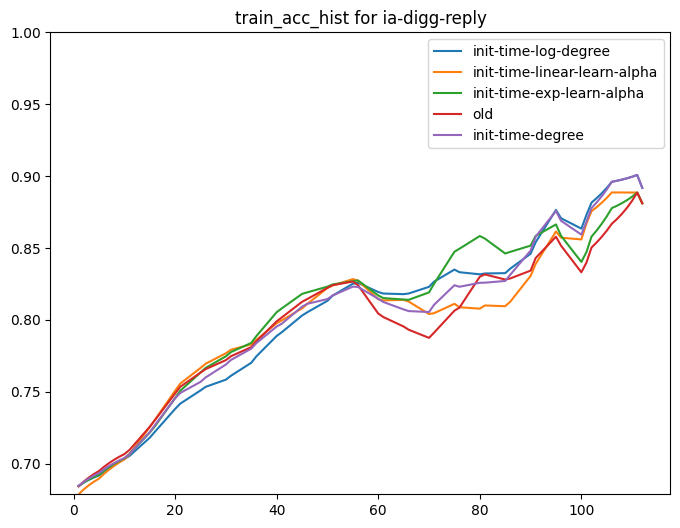

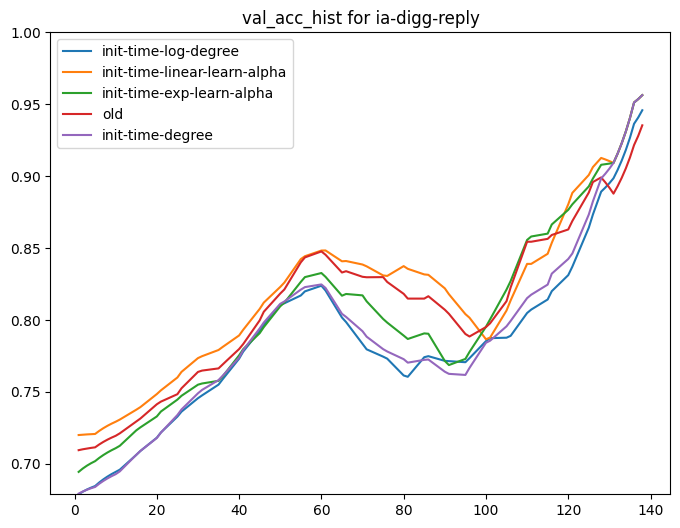

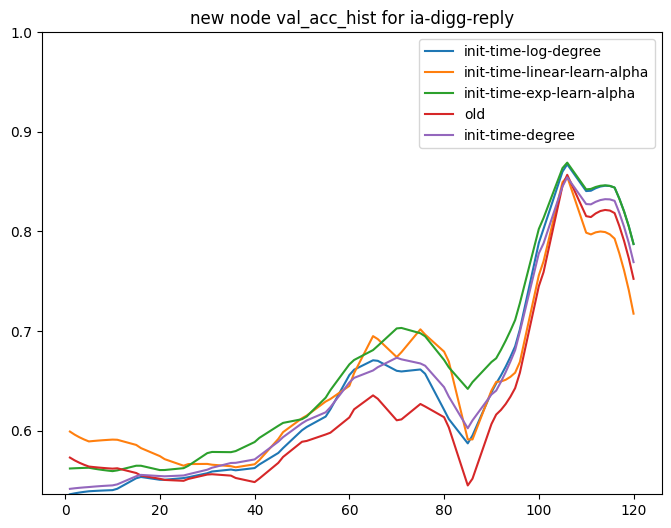

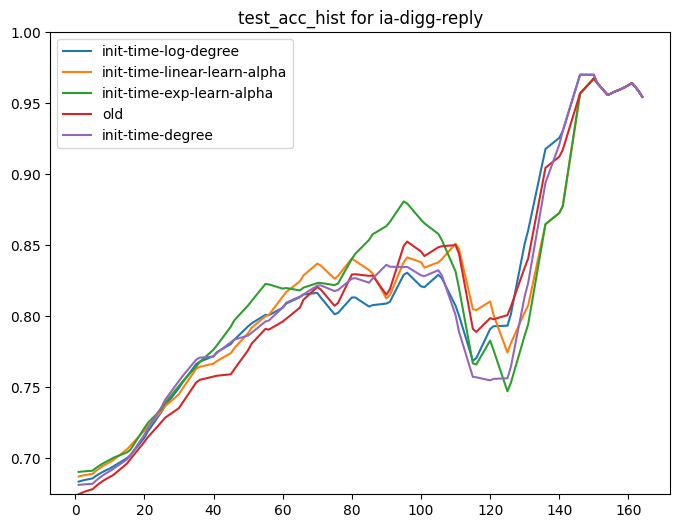

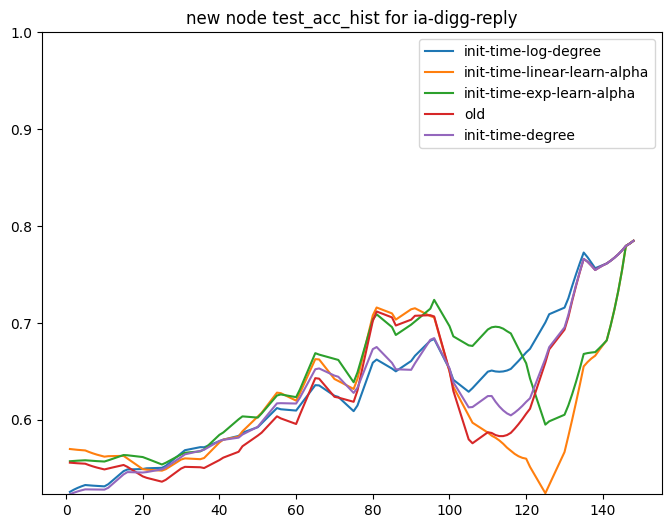

In [56]:
data_name = 'ia-digg-reply'
generate_combine_hists(data_name)

In [18]:
api = wandb.Api()
run = api.run(f"/fb-graph-proj/fb-graph-proj-dyglib/runs/jpp7vme0")
print(run.summary)
run.summary['test_loss'] = 0.2658
run.summary.update()

{'_timestamp': 1704864622.8613284, 'train_loss': {'min': 0.23194398468571345}, 'new node val average_precision': 0.9253885944374476, 'new node test average_precision': 0.9365360489713036, '_step': 41, 'test_loss': 0.2658, 'val average_precision': 0.9642710623015756, 'test average_precision': 0.9598691819415296, 'test roc_auc': {'max': 0.957818487394958}, 'train roc_auc': {'max': 0.9642339940649474}, 'new node test roc_auc': {'max': 0.9301795424690014}, 'train average_precision': 0.9642710623015756, '_wandb': {'runtime': 1468}, 'new node val_loss': {'min': 0.35462927964867136}, 'val roc_auc': {'max': 0.9642339940649474}, 'new node test loss': 0.3415547061269566, 'new node val roc_auc': {'max': 0.9190259221311476}, '_runtime': 1449.64683842659, 'val_loss': {'min': 0.255154035046321}}


In [10]:
import pandas as pd 
import wandb
api = wandb.Api()

runs = api.runs("fb-graph-proj/fb-graph-proj-dyglib", filters = {'dataset': "reddit"})

In [12]:
len(runs)

HTTPError: 400 Client Error: Bad Request for url: https://api.wandb.ai/graphql

In [5]:
run = runs[0]

In [7]:
hist = run.history(samples = 200, keys = ['train_acc_hist'])['train_acc_hist']

In [13]:
vals, bins = hist[0]['values'], hist[0]['bins']

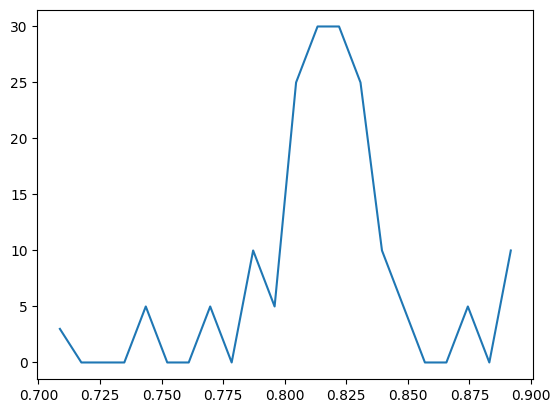

In [17]:
from matplotlib import pyplot as plt
plt.plot(bins[1:], vals)

In [23]:
runs = api.runs("fb-graph-proj/fb-graph-proj-dyglib", )

In [32]:
vals, bins

(array([4, 0, 1, 3, 4, 7, 0, 3, 2, 6]),
 array([0.00204809, 0.10064307, 0.19923805, 0.29783303, 0.39642801,
        0.495023  , 0.59361798, 0.69221296, 0.79080794, 0.88940292,
        0.9879979 ]))

In [42]:
import torch

def unique_entries_with_latest_index(tensor):
    # Find unique values and their corresponding indices
    unique_vals, inverse_indices = torch.unique(tensor, return_inverse=True)

    # Use `torch.argsort` to get the indices that would sort the unique tensor
    sorted_indices = torch.argsort(inverse_indices, descending=True)

    # Use `torch.unique_consecutive` to get the last occurrence of each unique value
    latest_indices = torch.unique_consecutive(inverse_indices[sorted_indices], return_counts=False)

    return unique_vals, latest_indices

# Example usage:
tensor = torch.tensor([1, 2, 3, 4, 2, 1, 4])
unique_vals, latest_indices = unique_entries_with_latest_index(tensor)
print("Unique Values:", unique_vals)
print("Latest Indices:", latest_indices)


Unique Values: tensor([1, 2, 3, 4])
Latest Indices: tensor([3, 2, 1, 0])


In [43]:
unique_vals, inverse_indices = torch.unique(tensor, return_inverse=True)
sorted_indices = torch.argsort(inverse_indices, descending=True)
latest_indices = torch.unique_consecutive(inverse_indices[sorted_indices], return_counts=False)

In [44]:
print(unique_vals, inverse_indices)

tensor([1, 2, 3, 4]) tensor([0, 1, 2, 3, 1, 0, 3])


In [45]:
unique, inverse = torch.unique(tensor, sorted=True, return_inverse=True)
perm = torch.arange(inverse.size(0), dtype=inverse.dtype, device=inverse.device)
inverse, perm = inverse, perm
perm = inverse.new_empty(unique.size(0)).scatter_(0, inverse, perm)

In [47]:
unique, perm

(tensor([1, 2, 3, 4]), tensor([5, 4, 2, 6]))

In [22]:
latest_indices 

tensor([2, 1, 0])

In [26]:
torch.sort(inverse_indices).indices

tensor([0, 4, 1, 3, 2])

In [28]:
values = torch.randn(5)
x = torch.zeros(5)

In [29]:
x[tensor] = values

In [30]:
values

tensor([-0.0334,  0.7015, -1.4659,  0.7154,  2.5038])

In [31]:
x

tensor([ 0.0000,  2.5038,  0.7154, -1.4659,  0.0000])

In [32]:
tensor

tensor([1, 2, 3, 2, 1])